In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from datetime import timedelta
import datetime as dt
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from math import radians, cos, sin, asin, sqrt
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline

# Exploratory Data Analysis

Here we are going to experiment with our data in order to get the most insights possible before building a Machine Learning Model

In [2]:
#import data for the analysis

base_train = pd.read_csv('train.csv')
base_test = pd.read_csv('test.csv')
base_train.head()

train = base_train
test = base_test

In [3]:
#Filtering outliers

m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

## Creating Datetime Variables

In [4]:
## Adjusting datetime data

def clean_datetime(df):
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
    df.loc[:, 'pickup_week'] = df.pickup_datetime.apply(lambda x: x.isocalendar()[1])
    df.loc[:, 'pickup_weekday'] = df.pickup_datetime.apply(lambda x: x.weekday())
    df.loc[:, 'pickup_hour'] = df.pickup_datetime.apply(lambda x: x.hour)
    return df

train = clean_datetime(train)
test = clean_datetime(test)

## Transforming and Normalizing the target variable

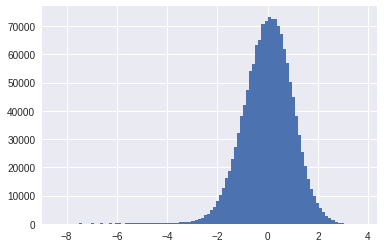

In [5]:
train['log_duration'] = np.log(train['trip_duration'].values)
#maybe also normalize it
#Saving the mean and standard devition to revert the transformation
logmean = train['log_duration'].mean()
logstd = train['log_duration'].std()

train['log_duration'] = (train.log_duration - logmean)/logstd

plt.hist(train['log_duration'].values, bins = 100)
plt.show()

## Analyzing Position Variables

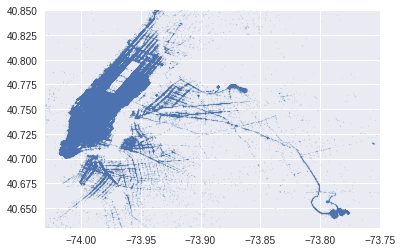

In [6]:
xlim = (-74.03, -73.75)
ylim = (40.63, 40.85)

plt.scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,  s = 1, alpha = 0.1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

Here we are going to create new positional values, these are the haversine distance and the manhattan distance, the manhatan distance is just the sum of the individual distances.

In [6]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h

def L1_distance(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def create_distances(df):
    df.loc[:, 'haversine'] = haversine(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
    df.loc[:, 'l1_dist'] = L1_distance(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values)
    df.loc[:, 'direction'] = bearing_array(df['pickup_latitude'].values, df['pickup_longitude'].values, df['dropoff_latitude'].values, df['dropoff_longitude'].values) 
    return df

In [7]:
train = create_distances(train)
test = create_distances(test)

## Getting rid of unwanted variables

In [8]:

#Creating label vector
ydata = train['log_duration']
ytarget = train['trip_duration']

## Helper Data

In [9]:
fr1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('fastest_routes_test.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

## Transformation and normalization  of positional variables

First we want to see how some features relate to the target variable. W could apply a logarithmic transform to make it look better, we can also normalize it

In [10]:
def normalize(series): return (series - series.mean())/series.std()

def log_trans(series): return series.apply(lambda x: np.log(x + 0.01))

def add_normalized(df):
    df.loc[:,'l1_dist_norm'] = normalize(log_trans(df.l1_dist))
    df.loc[:,'haversine_norm'] = normalize(log_trans(df.haversine))
    df.loc[:,'direction_norm'] = normalize(df.haversine)
    df.loc[:,'pickup_longitude_norm'] = normalize(df.pickup_longitude * -1)
    df.loc[:,'pickup_latitude_norm'] = normalize(df.pickup_latitude)
    df.loc[:,'dropoff_longitude_norm'] = normalize(df.dropoff_longitude * -1)
    df.loc[:,'dropoff_latitude_norm'] = normalize(df.dropoff_latitude)
    df.loc[:,'total_travel_time_norm'] = normalize(log_trans(df.total_travel_time))
    df.loc[:,'total_distance_norm'] = normalize(log_trans(df.total_distance))
    df.loc[:,'number_of_steps_norm'] = normalize(df.number_of_steps)
    return df

In [11]:
train = add_normalized(train)
test = add_normalized(test)

## Training the model

In [12]:
## get the dummy variables
def build_data_matrix(df):
    return pd.concat([df['l1_dist_norm'],
                      df['haversine_norm'],
                      df['direction_norm'],
                      df['total_travel_time_norm'],
                      df['total_distance_norm'],
                      #df['pickup_longitude_norm'],
                      #df['pickup_latitude_norm'],
                      #df['dropoff_longitude_norm'],
                      #df['dropoff_latitude_norm'],
                      #df['number_of_steps_norm'],
                      pd.get_dummies(df.pickup_hour), 
                      pd.get_dummies(df.pickup_week), 
                      pd.get_dummies(df.pickup_weekday)], axis = 1).as_matrix()

Xdata = build_data_matrix(train)
Xtest = build_data_matrix(test)

In [14]:
Xdata = np.nan_to_num(Xdata)

In [18]:
def delog(y, mean, std):
    res = y*std + mean
    res = np.exp(res) + 0.01
    return res

def rmsle(predicted, real):
    """Root mean square logarithmic error."""
    sum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return np.sqrt(sum/len(predicted))

In [ ]:

from sklearn.neural_network import MLPRegressor as regressor

clf = regressor(verbose=True, hidden_layer_sizes=(100, 3))
clf = clf.fit(Xdata, ydata)

In [ ]:

ypredlogtrain = clf.predict(Xdata)
ypredlogtrain = np.array(ypredlogtrain)
ypredtrain = delog(ypredlogtrain, logmean, logstd)

errortrain = rmsle(ypredtrain, ytarget)
print(errortrain)

## Submission

In [34]:
ypredlog = clf.predict(Xtest)
ypredlog = np.array(ypredlog)
ypred = delog(ypredlog, logmean, logstd)

submission = pd.concat([test['id'],pd.DataFrame(ypred)], axis = 1)
submission.columns = ['id', 'trip_duration']
submission.to_csv('submission.csv', index = False)